<a href="https://colab.research.google.com/github/panjaphon-kmitl/edav-cleaning-2/blob/main/edav_cleaning_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
import plotly.express as px

In [2]:
import pandas as pd
import numpy as np
import random
import os
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from plotly.subplots import make_subplots

In [3]:
import missingno as msno

In [4]:
random.seed(0)
np.random.seed(0)

# Read file

In [5]:
files = {
    'AmazonSaleReport':r'https://raw.githubusercontent.com/panjaphon-kmitl/edav-cleaning-2/main/Amazon%20Sale%20Report.csv',
    'CreditCard':r'https://raw.githubusercontent.com/panjaphon-kmitl/edav-cleaning-2/main/BankChurners.csv',
    'ECommerce':r'https://raw.githubusercontent.com/panjaphon-kmitl/edav-cleaning-2/main/health_and_wellness_cleaned_20230810_213000.csv'
}

original = pd.read_csv(files['AmazonSaleReport'])

# Functions

In [6]:
# Check types
def check_types(df):
    data_types = df.dtypes.sort_values().reset_index()
    data_types.columns = ['name', 'data_type']

    return data_types


# Check dup
def check_dup(df):
    print("Duplicated rows: ", df.duplicated().sum())


# Check null
def check_nulls(df):
    total_rows = df.shape[0]

    nulls = df.isna().sum(axis=0).reset_index()
    nulls.columns = ['name', 'null_records']
    nulls['null_records_pct'] = (round(nulls['null_records'] / total_rows, 2) * 100)
    nulls = nulls[nulls['null_records'] > 0]
    nulls = nulls.sort_values(by='null_records_pct', ascending=False)

    return nulls


# Plot categorical
def plot_categorical(df, column, orientation='v', width=None, height=None, head=None, tickangle=45):
    x = column
    y = 'count'

    if orientation == 'h':
        x, y = y, x

    sorted_data = df[column].value_counts(sort=True, ascending=True).reset_index()
    if head is not None:
        sorted_data = sorted_data.head(head)

    fig = px.bar(data_frame=sorted_data, x=x, y=y, orientation=orientation)

    if width is not None:
        fig.update_layout(width=width)

    if height is not None:
        fig.update_layout(height=height)

    return fig


# Plot numerical
def plot_numerical(df, columns):
    fig = make_subplots(rows=1, cols=len(columns))

    for index, column in enumerate(columns):
        fig.add_trace(go.Box(y=df[column], name=column), row=1, col=index+1)

    fig.update_layout(
        autosize=False,
        width=1000,
        height=600,
    )
    fig.show()


# Clean dups
def clean_dups(df):
    print('Rows before dropping', df.shape[0])
    print('')

    df.drop_duplicates()

    print('Rows after dropping', df.shape[0])



# Create NULLs
def create_nulls(df, column_name, p):
    num_records_to_nullify = int(len(df) * p)
    indices_to_nullify = np.random.choice(df.index, num_records_to_nullify, replace=False)
    df.loc[indices_to_nullify, column_name] = np.nan

    return df


# Create Dups
def create_dups(df, num_duplicates=5):
    # Randomly select rows to duplicate
    rows_to_duplicate = df.copy().sample(n=num_duplicates, replace=True)

    # Append the duplicated rows to the original DataFrame
    df_with_duplicates = pd.concat([df, rows_to_duplicate], ignore_index=True)

    return df_with_duplicates


# Mistype
def random_mistype_size(df, column_name, randomness):
    possible_mistypes = {
      'S': ['Small', 'S'],
      '3XL': ['3XL', 'XXXL'],
    #   'XL': ['XL', 'XLarge'],
      'L': ['L', 'Large'],
    #   'XXL': ['XXL', 'XXLarge'],
    #   'XS': ['XS', 'XSmall'],
    #   '6XL': ['6XL', 'XXXXXXL'],
      'M': ['M', 'Medium'],
      '4XL': ['4XL', 'XXXXL'],
    #   'Free': ['Free', 'One Size'],
    #   '5XL': ['5XL', 'XXXXXL']
      }

    new_column = df[column_name].apply(lambda x: random.choice(possible_mistypes.get(x, [x])) if random.random() < randomness else x)
    return new_column


# Drop IQR
def drop_out_of_bound(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1

    lower = q1 - (1.5 * iqr)
    upper = q3 + (1.5 * iqr)

    df = df[(df[column] >= lower) & (df[column] <= upper)]

    return df


# Fix typo
def fix_inconsistency(df, column_name, mapping):
    new_column = df[column_name].replace(mapping)
    return new_column


def clean_postal_code(df, column_name):
    output = df[column_name].copy()
    output = output.astype(str)
    output = output.str.extract(r'(\d+)\.')

    return output

# ✅ (ต้น) วางยา

In [7]:
original.head(2)

,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Category,Size,Courier Status,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,B2B,fulfilled-by,New,PendingS
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,T-shirt,S,On the Way,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,False,Easy Ship,NaN,NaN
1,1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,Shirt,3XL,Shipped,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,False,Easy Ship,NaN,NaN


In [8]:
# ทำ Row Dup
dup_rows = 12
df_with_duplicates = original.copy()
df_with_duplicates = create_dups(df_with_duplicates, num_duplicates=dup_rows)

In [9]:
# พิมพ์ผิด
df_mistyped = df_with_duplicates.copy()
df_mistyped['Size'] = random_mistype_size(df_mistyped, 'Size', 0.02)

# (แชมป์) EDA + ค่าสถิติก่อนคลีน

In [10]:
eda = df_mistyped.copy()

## Basic

In [11]:
# Data profiling
eda.sample(5)

,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Category,Size,Courier Status,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,B2B,fulfilled-by,New,PendingS
25006,25005,405-0087569-1016348,04-15-22,Cancelled,Amazon,Amazon.in,Expedited,Blazzer,S,Unshipped,...,INR,899.0,BENGALURU,KARNATAKA,560048.0,IN,False,NaN,NaN,NaN
50239,50238,403-3679535-8428325,05-31-22,Shipped,Amazon,Amazon.in,Expedited,Shirt,XXL,Shipped,...,INR,382.0,NEW DELHI,DELHI,110093.0,IN,False,NaN,NaN,NaN
109718,109717,406-0483030-5907555,06-14-22,Shipped,Amazon,Amazon.in,Expedited,Shirt,M,Shipped,...,INR,468.0,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,False,NaN,NaN,NaN
51750,51749,171-7681702-9321947,05-29-22,Shipped,Amazon,Amazon.in,Expedited,T-shirt,XXL,Shipped,...,INR,788.0,New Delhi,Delhi,110019.0,IN,False,NaN,NaN,NaN
39585,39584,408-6580596-5759545,04-06-2022,Shipped,Amazon,Amazon.in,Expedited,T-shirt,3XL,Shipped,...,INR,696.0,KOTTAYAM,KERALA,686006.0,IN,False,NaN,NaN,NaN


In [12]:
# Data profiling : data types
check_types(eda)

,name,data_type
0,B2B,bool
1,index,int64
2,Qty,int64
3,PendingS,float64
4,ship-postal-code,float64
5,New,float64
6,Amount,float64
7,fulfilled-by,object
8,Order ID,object
9,ship-country,object


In [13]:
original.columns

Index(['index', 'Order ID', 'Date', 'Status', 'Fulfilment', 'Sales Channel',
       'ship-service-level', 'Category', 'Size', 'Courier Status', 'Qty',
       'currency', 'Amount', 'ship-city', 'ship-state', 'ship-postal-code',
       'ship-country', 'B2B', 'fulfilled-by', 'New', 'PendingS'],
      dtype='object')

In [14]:
# Data profiling : NULL values
check_nulls(eda)

,name,null_records,null_records_pct
19,New,128988,100.0
20,PendingS,128988,100.0
18,fulfilled-by,89722,70.0
11,currency,7801,6.0
12,Amount,7801,6.0
13,ship-city,35,0.0
14,ship-state,35,0.0
15,ship-postal-code,35,0.0
16,ship-country,35,0.0


In [15]:
# Data profiling : Duplicated rows
check_dup(eda)

Duplicated rows:  177


In [16]:
# Column groups
id_columns = ['index', 'order_id']
date_columns = ['Date']
localtion_columns = ['ship_city', 'ship_state', 'ship_postal_code']

## Date column

In [17]:
# Explore date column
print('Date column has different lengths:')
eda['Date'].str.len().value_counts()

Date column has different lengths:


,count
Date,
8,73872
10,55116


In [18]:
# Explore date column
eda_date_10 = eda[eda['Date'].str.len() == 10][['Date']].drop_duplicates().reset_index(drop=1)
eda_date_10[['Date_1', 'Date_2', 'Date_3']] = eda_date_10['Date'].str.split('-', expand=True)
eda_date_10[['Date_1', 'Date_2', 'Date_3']] = eda_date_10[['Date_1', 'Date_2', 'Date_3']].astype(int)
eda_date_10[['Date_1', 'Date_2', 'Date_3']].describe().astype(int).loc[['min', 'max'],:]

,Date_1,Date_2,Date_3
min,4,1,2022
max,6,12,2022


In [19]:
# Explore date column
eda_date_8 = eda[eda['Date'].str.len() == 8][['Date']].drop_duplicates().reset_index(drop=1)
eda_date_8[['Date_1', 'Date_2', 'Date_3']] = eda_date_8['Date'].str.split('-', expand=True)
eda_date_8[['Date_1', 'Date_2', 'Date_3']] = eda_date_8[['Date_1', 'Date_2', 'Date_3']].astype(int)
eda_date_8[['Date_1', 'Date_2', 'Date_3']].describe().astype(int).loc[['min', 'max'],:]

,Date_1,Date_2,Date_3
min,3,13,22
max,6,31,22


In [20]:
# Conclusion
# If date_length = 8, format = '%m-%d-%y'
# If date_length = 10, format = '%m-%d-%Y' or '%d-%m-%Y'

## Categorical columns

In [30]:
# Sample data (you should replace this with your actual DataFrame)
CourierStatus_counts = eda['Courier Status'].value_counts().sort_values(ascending=True)

# Define the color scale
colorscale = [[0, 'lightgreen'], [1, 'blue']]

# Create the bar chart with labels
fig = go.Figure(data=[go.Bar(
    x=CourierStatus_counts.values,
    y=CourierStatus_counts.index,
    text=CourierStatus_counts.values,  # Add text (labels) on top of bars
    orientation='h',
    textposition='auto',  # 'auto' places the labels either inside or above bars depending on space
    marker=dict(
        color=CourierStatus_counts.values,  # Color based on the values
        colorscale=colorscale,  # Apply the color scale
        colorbar=dict(title="Count")  # Adds a color bar
    )
)])

# Set the title and axis labels
fig.update_layout(
    autosize=False,
    width=800,  # Increased width to accommodate all plots
    height=400, # Increased height to accommodate all plots
    title='Courier Status',
    xaxis_title='Count',
    yaxis_title='Status',
    template='plotly'
)


# Show the figure
fig.show()


In [31]:
valid_statuses = ['Shipped', 'Shipped - Delivered to Buyer', 'Shipped - Picked Up', 'Shipped - Out for Delivery']
shipped_good = eda['Status'].apply(lambda x: 1 if x in valid_statuses else 0).sum()
print(shipped_good)

107589


In [32]:
# Sample data (you should replace this with your actual DataFrame)
status_counts = eda['Status'].value_counts()

# Define the color scale
colorscale = [[0, 'lightgreen'], [1, 'blue']]

# Create the bar chart with labels
fig = go.Figure(data=[go.Bar(
    x=status_counts.index,
    y=status_counts.values,
    text=status_counts.values,  # Add text (labels) on top of bars
    textposition='auto',  # 'auto' places the labels either inside or above bars depending on space
    marker=dict(
        color=status_counts.values,  # Color based on the values
        colorscale=colorscale,  # Apply the color scale
        colorbar=dict(title="Count")  # Adds a color bar
    )
)])

# Set the title and axis labels
fig.update_layout(
     autosize=False,
    width=1000,  # Increased width to accommodate all plots
    height=600, # Increased height to accommodate all plots
    title='All shipping Status',
    xaxis_title='Status',
    yaxis_title='Count',
    template='plotly'
)

# Show the figure
fig.show()


In [33]:
valid_statuses = ['Shipped', 'Shipped - Delivered to Buyer', 'Shipped - Picked Up', 'Shipped - Out for Delivery']
shipped_good = eda['Status'].apply(lambda x: 1 if x in valid_statuses else 0).sum()
print('Status ok',shipped_good)

valid_statuses = ['Shipped', 'Shipped - Delivered to Buyer', 'Shipped - Picked Up', 'Shipped - Out for Delivery']
shipped_bad = eda['Status'].apply(lambda x: 1 if x not in valid_statuses else 0).sum()
print('Status not ok',shipped_bad)

Status ok 107589
Status not ok 21399


In [34]:
# Define the color scale
colorscale = [[0, 'lightgreen'], [1, 'blue']]

# Create the bar chart with labels
fig = go.Figure(data=[go.Bar(
    x=[shipped_bad,shipped_good],
    y=['Normal conditon', 'Abnormal condition'],
    text=[shipped_bad,shipped_good],  # Add text (labels) on top of bars
    textposition='auto',  # 'auto' places the labels either inside or above bars depending on space
    orientation='h',
    marker=dict(
        color=[shipped_bad,shipped_good],  # Color based on the values
        colorscale=colorscale,  # Apply the color scale
        colorbar=dict(title="Count")  # Adds a color bar
    )
)])

# Set the title and axis labels
fig.update_layout(
    autosize=False,
    width=600,  # Increased width to accommodate all plots
    height=400, # Increased height to accommodate all plots
    title='Normal vs Abnormal Shipping status',
    xaxis_title='Status',
    yaxis_title='Count',
    template='plotly'
)

# Show the figure
fig.show()


In [35]:
shipped_df = eda[eda['Courier Status'] == 'Shipped']


In [36]:
# Sample data (you should replace this with your actual DataFrame)
status_counts = shipped_df['Status'].value_counts()

# Define the color scale
colorscale = [[0, 'lightgreen'], [1, 'blue']]

# Create the bar chart with labels
fig = go.Figure(data=[go.Bar(
    x=status_counts.index,
    y=status_counts.values,
    text=status_counts.values,  # Add text (labels) on top of bars
    textposition='auto',  # 'auto' places the labels either inside or above bars depending on space
    marker=dict(
        color=status_counts.values,  # Color based on the values
        colorscale=colorscale,  # Apply the color scale
        colorbar=dict(title="Count")  # Adds a color bar
    )
)])

# Set the title and axis labels
fig.update_layout(
    autosize=False,
    width=1000,  # Increased width to accommodate all plots
    height=600, # Increased height to accommodate all plots
    title='Shipped sub Status',
    xaxis_title='Status',
    yaxis_title='Count',
    template='plotly'
)

# Show the figure
fig.show()


In [37]:
OTW_df = eda[eda['Courier Status'] == 'On the Way']


In [38]:
# Sample data (you should replace this with your actual DataFrame)
status_counts = OTW_df['Status'].value_counts().sort_values(ascending=True)

# Define the color scale
colorscale = [[0, 'lightgreen'], [1, 'blue']]

# Create the bar chart with labels
fig = go.Figure(data=[go.Bar(
    x=status_counts.values,
    y=status_counts.index,
    text=status_counts.values,  # Add text (labels) on top of bars
    textposition='auto',  # 'auto' places the labels either inside or above bars depending on space
    orientation='h',
    marker=dict(
        color=status_counts.values,  # Color based on the values
        colorscale=colorscale,  # Apply the color scale
        colorbar=dict(title="Count")  # Adds a color bar
    )
)])

# Set the title and axis labels
fig.update_layout(
    autosize=False,
    width=600,  # Increased width to accommodate all plots
    height=400, # Increased height to accommodate all plots
    title='On the way sub Status',
    xaxis_title='Status',
    yaxis_title='Count',
    template='plotly'
)

# Show the figure
fig.show()


In [39]:
Unshipped_df = eda[eda['Courier Status'] == 'Unshipped']


In [40]:
# Sample data (you should replace this with your actual DataFrame)
status_counts = Unshipped_df['Status'].value_counts()

# Define the color scale
colorscale = [[0, 'lightgreen'], [1, 'blue']]

# Create the bar chart with labels
fig = go.Figure(data=[go.Bar(
    x=status_counts.index,
    y=status_counts.values,
    text=status_counts.values,  # Add text (labels) on top of bars
    textposition='auto',  # 'auto' places the labels either inside or above bars depending on space
    marker=dict(
        color=status_counts.values,  # Color based on the values
        colorscale=colorscale,  # Apply the color scale
        colorbar=dict(title="Count")  # Adds a color bar
    )
)])

# Set the title and axis labels
fig.update_layout(
    autosize=False,
    width=600,  # Increased width to accommodate all plots
    height=400, # Increased height to accommodate all plots
    title='Unshipped sub Status',
    xaxis_title='Status',
    yaxis_title='Count',
    template='plotly'
)

# Show the figure
fig.show()


In [41]:
Cancelled_df = eda[eda['Courier Status'] == 'Unshipped']


In [42]:
# Sample data (you should replace this with your actual DataFrame)
status_counts = Cancelled_df['Status'].value_counts()

# Define the color scale
colorscale = [[0, 'lightgreen'], [1, 'blue']]

# Create the bar chart with labels
fig = go.Figure(data=[go.Bar(
    x=status_counts.index,
    y=status_counts.values,
    text=status_counts.values,  # Add text (labels) on top of bars
    textposition='auto',  # 'auto' places the labels either inside or above bars depending on space
    marker=dict(
        color=status_counts.values,  # Color based on the values
        colorscale=colorscale,  # Apply the color scale
        colorbar=dict(title="Count")  # Adds a color bar
    )
)])

# Set the title and axis labels
fig.update_layout(
    autosize=False,
    width=600,  # Increased width to accommodate all plots
    height=400, # Increased height to accommodate all plots
    title='Unshipped sub Status',
    xaxis_title='Status',
    yaxis_title='Count',
    template='plotly'
)

# Show the figure
fig.show()


In [43]:
# Sample data (you should replace this with your actual DataFrame)
fulfilment_counts = eda['Fulfilment'].value_counts()

fig = go.Figure(data=[go.Pie(
    labels=fulfilment_counts.index,
    values=fulfilment_counts.values,
    textinfo='label+percent',
    insidetextorientation='radial',
    textposition='auto',
    )])

# Set the title and axis labels
fig.update_layout(
    autosize=False,
    width=500,  # Increased width to accommodate all plots
    height=500, # Increased height to accommodate all plots
    title='Fulfilment Type',
    template='plotly'
)

# Show the figure
fig.show()

In [44]:
# Sample data (you should replace this with your actual DataFrame)
SalesChannel_counts = eda['Sales Channel'].value_counts()

fig = go.Figure(data=[go.Pie(
    labels=SalesChannel_counts.index,
    values=SalesChannel_counts.values,
    textinfo='label+percent',
    insidetextorientation='radial',
    textposition='auto',
    )])

# Set the title and axis labels
fig.update_layout(
    autosize=False,
    width=500,  # Increased width to accommodate all plots
    height=500, # Increased height to accommodate all plots
    title='Sales channel',
    template='plotly'
)

# Show the figure
fig.show()

In [45]:
# Sample data (you should replace this with your actual DataFrame)
ShipServiceLevel_counts = eda['ship-service-level'].value_counts()

fig = go.Figure(data=[go.Pie(
    labels=ShipServiceLevel_counts.index,
    values=ShipServiceLevel_counts.values,
    textinfo='label+percent',
    insidetextorientation='radial',
    textposition='auto',
    )])

# Set the title and axis labels
fig.update_layout(
    autosize=False,
    width=500,  # Increased width to accommodate all plots
    height=500, # Increased height to accommodate all plots
    title='Ship Service Level',
    template='plotly'
)

# Show the figure
fig.show()

In [46]:
# Sample data (you should replace this with your actual DataFrame)
Category_counts = eda['Category'].value_counts()

# Define the color scale
colorscale = [[0, 'lightgreen'], [1, 'blue']]

fig = go.Figure(data=[go.Bar(
    x=Category_counts.index,
    y=Category_counts.values,
    text=Category_counts.values,  # Add text (labels) on top of bars
    textposition='auto',  # 'auto' places the labels either inside or above bars depending on space
    marker=dict(
        color=status_counts.values,  # Color based on the values
        colorscale=colorscale,  # Apply the color scale
        colorbar=dict(title="Count")  # Adds a color bar
    )
)])

# Set the title and axis labels
fig.update_layout(
    autosize=False,
    width=1000,  # Increased width to accommodate all plots
    height=600, # Increased height to accommodate all plots
    title='Product Category',
    xaxis_title='Category',
    yaxis_title='Count',
    template='plotly'
)

# Show the figure
fig.show()

In [47]:
Tshirt_df = eda[eda['Category'] == 'T-shirt']


In [48]:
# Sample data (you should replace this with your actual DataFrame)
Tshirt_size_counts = Tshirt_df['Size'].value_counts()

fig = go.Figure(data=[go.Pie(
    labels=Tshirt_size_counts.index,
    values=Tshirt_size_counts.values,
    textinfo='label+percent',
    insidetextorientation='radial',
    textposition='auto',
    )])

# Set the title and axis labels
fig.update_layout(
    autosize=False,
    width=800,  # Increased width to accommodate all plots
    height=500, # Increased height to accommodate all plots
    title='T-shirt sales by size',
    template='plotly'
)

# Show the figure
fig.show()

In [49]:
Shirt_df = eda[eda['Category'] == 'Shirt']


In [50]:
# Sample data (you should replace this with your actual DataFrame)
Shirt_size_counts = Shirt_df['Size'].value_counts()

fig = go.Figure(data=[go.Pie(
    labels=Shirt_size_counts.index,
    values=Shirt_size_counts.values,
    textinfo='label+percent',
    insidetextorientation='radial',
    textposition='auto',
    )])

# Set the title and axis labels
fig.update_layout(
    autosize=False,
    width=800,  # Increased width to accommodate all plots
    height=500, # Increased height to accommodate all plots
    title='Shirt sales by size',
    template='plotly'
)

# Show the figure
fig.show()

In [51]:
Blazzer_df = eda[eda['Category'] == 'Blazzer']


In [52]:
# Sample data (you should replace this with your actual DataFrame)
Blazzer_size_counts = Blazzer_df['Size'].value_counts()

fig = go.Figure(data=[go.Pie(
    labels=Blazzer_size_counts.index,
    values=Blazzer_size_counts.values,
    textinfo='label+percent',
    insidetextorientation='radial',
    textposition='auto',
    )])

# Set the title and axis labels
fig.update_layout(
    autosize=False,
    width=800,  # Increased width to accommodate all plots
    height=500, # Increased height to accommodate all plots    title='Shirt sales by size',
    template='plotly'
)

# Show the figure
fig.show()

In [53]:
category_counts = eda.groupby(['Qty', 'Category']).size().reset_index(name='Count')
more_than_one = category_counts[category_counts['Qty'] > 1]

In [54]:
fig = go.Figure(data=go.Heatmap(
                   z=more_than_one['Count'],
                   x=more_than_one['Qty'],
                   y=more_than_one['Category'],
                   hoverongaps = False))

fig.update_layout(
    autosize=False,
    width=800,  # Increased width to accommodate all plots
    height=400, # Increased height to accommodate all plots
    title='More than one piece order',
    xaxis_title='Quantity',
    yaxis_title='Product category',
    template='plotly'
)

fig.show()

## Numerical columns

In [55]:
fig = go.Figure(data=[go.Box(y=eda['Amount'],
                             marker_color='#AB63FA',
                             name="Amount")])

fig.update_layout(
    autosize=False,
    width=600,  # Increased width to accommodate all plots
    height=600, # Increased height to accommodate all plots
    title='Amount per Order',
    template='plotly'
)

fig.show()

In [56]:
fig = go.Figure(data=[go.Box(y=eda['Qty'],
                             marker_color='#FFA15A',
                             name="Quantity")])

fig.update_layout(
    autosize=False,
    width=600,  # Increased width to accommodate all plots
    height=600, # Increased height to accommodate all plots
    title='Quantity per Order',
    template='plotly'
)

fig.show()

# (แบงค์) Cleaning

In [57]:
# เปลี่ยนชื่อคอลัมน์ให้เป็นทิศทางเดียวกัน
new_column_names = df_mistyped.columns
new_column_names = new_column_names.str.lower().str.replace(' ', '_').str.replace('-', '_')
df_mistyped.columns = new_column_names

In [58]:
# # Duplicates
df_dul=df_mistyped.copy()
df_dul[df_dul.duplicated()]
df_dul.drop_duplicates(inplace=True)

In [59]:
# Typo : Upper, Lower --> ship_city, ship_state
df_typo=df_dul.copy()
df_typo["ship_city"] = df_typo["ship_city"].str.title()
df_typo["ship_state"] = df_typo["ship_state"].str.title()

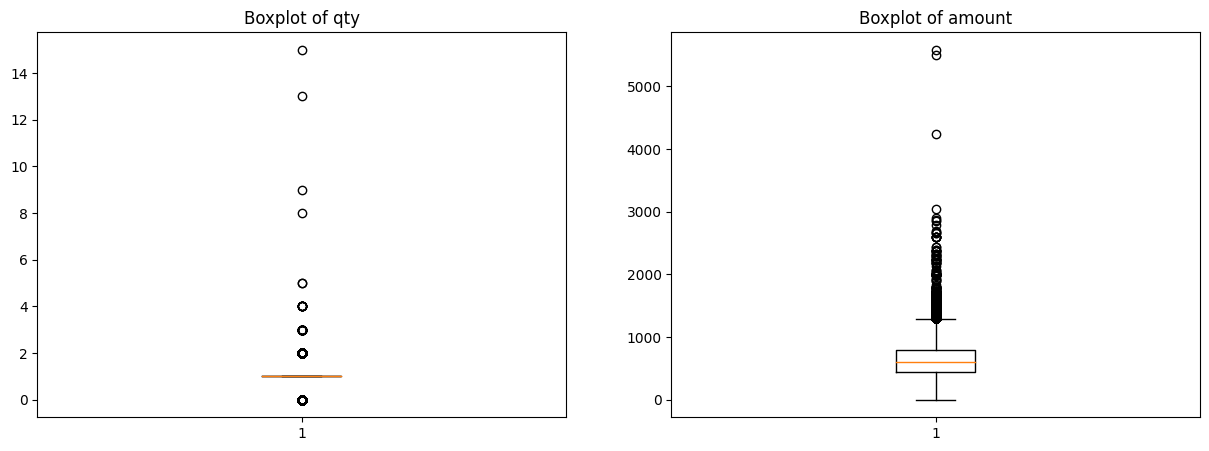

In [60]:
# Outliers

# สร้าง subplot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].boxplot(df_typo['qty'].dropna())
axes[0].set_title("Boxplot of qty")

axes[1].boxplot(df_typo['amount'].dropna())
axes[1].set_title("Boxplot of amount")

plt.show()

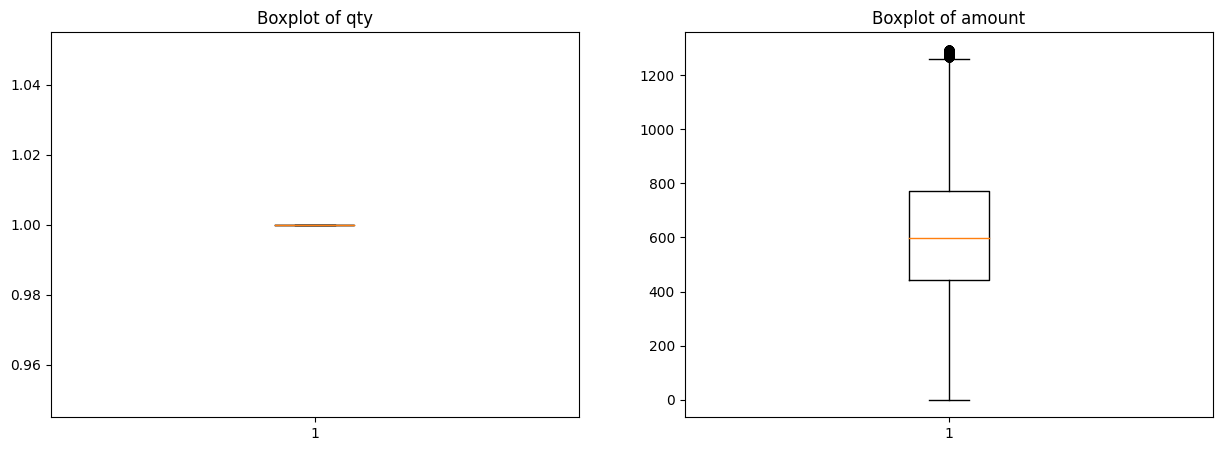

In [61]:
# Number outliers (IQR Method)
df_typo_out = df_typo.copy()

for col in ['qty', 'amount']:
    df_typo_out = drop_out_of_bound(df_typo_out, col)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].boxplot(df_typo_out['qty'])
axes[0].set_title("Boxplot of qty")

axes[1].boxplot(df_typo_out['amount'])
axes[1].set_title("Boxplot of amount")

plt.show()

# (ต้น) Cleaning

In [62]:
# (Done) Data Types --> ship_postal_code
# (Done) Mistype : M -> Middle, L -> Large
# (Done) NULLs
# (Done) ปลี่ยนชื่อคอลัมน์ให้ไปในทิศทางเดียวกัน
# (Done) คอลัมน์ date คนละฟอร์แมตกัน

In [63]:
df_clean_ton = df_typo_out.copy()

## Data type (ship_postal_code)

In [64]:
df_clean_ton['ship_postal_code'] = clean_postal_code(df_clean_ton, 'ship_postal_code')

## Mistype

In [65]:
# Before cleaning
plot_categorical(df_clean_ton, 'size', 'v', width=1000, height=300)

In [66]:
# After cleaning
possible_sizes = {
    'XXXXL':'4XL',
    'XXXL':'3XL',
    'Large':'L',
    'Medium':'M',
    'Small':'S',
    }
df_clean_ton['size'] = fix_inconsistency(df_clean_ton, 'size', possible_sizes)
plot_categorical(df_clean_ton, 'size', 'v', width=1000, height=300)

## NULLs

In [67]:
check_nulls(df_clean_ton)

,name,null_records,null_records_pct
19,new,112115,100.0
20,pendings,112115,100.0
18,fulfilled_by,80824,72.0
13,ship_city,27,0.0
14,ship_state,27,0.0
15,ship_postal_code,27,0.0
16,ship_country,27,0.0


In [68]:
null_columns = ['new', 'pendings']
df_clean_ton = df_clean_ton.drop(columns=null_columns)

## Date

In [69]:
df_clean_ton['date'] = pd.to_datetime(df_clean_ton['date'].replace('-2022', '-22', regex=True), format='%m-%d-%y')

## (optional) Irrelevent

In [70]:
irrelevent_columns = ['order_id', 'index']
one_value_columns = ['currency', 'ship_country']

df_clean_ton = df_clean_ton.drop(columns=irrelevent_columns + one_value_columns)

# (พี่ต้น) เปรียบเทียบก่อนหลัง

## คอลัมน์​ Qty

In [86]:
df_typo['qty'].value_counts()

,count
qty,
1,115632
0,12792
2,340
3,32
4,9
5,2
15,1
9,1
13,1


In [80]:
# Before
fig = go.Figure(data=[go.Box(y=df_typo['qty'],
                             marker_color='#AB63FA',
                             name="Amount")])

fig.update_layout(
    autosize=False,
    width=600,  # Increased width to accommodate all plots
    height=600, # Increased height to accommodate all plots
    title='Quantity per Order',
    template='plotly'
)

fig.show()

In [81]:
# After
fig = go.Figure(data=[go.Box(y=df_typo_out['qty'],
                             marker_color='#AB63FA',
                             name="Amount")])

fig.update_layout(
    autosize=False,
    width=600,  # Increased width to accommodate all plots
    height=600, # Increased height to accommodate all plots
    title='Quantity per Order',
    template='plotly'
)

fig.show()

## คอลัมน์​ Amout

In [94]:
eda[~eda['Status'].str.contains('Cancelled')]['Amount'].value_counts(sort=True)

,count
Amount,
399.0,5128
771.0,2689
735.0,2361
0.0,2345
487.0,2173
...,...
535.0,1
1934.0,1
398.0,1


In [82]:
# Before
fig = go.Figure(data=[go.Box(y=df_typo['amount'],
                             marker_color='#AB63FA',
                             name="Amount")])

fig.update_layout(
    autosize=False,
    width=600,  # Increased width to accommodate all plots
    height=600, # Increased height to accommodate all plots
    title='Amount per Order',
    template='plotly'
)

fig.show()

In [83]:
# After
fig = go.Figure(data=[go.Box(y=df_typo_out['amount'],
                             marker_color='#AB63FA',
                             name="Amount")])

fig.update_layout(
    autosize=False,
    width=600,  # Increased width to accommodate all plots
    height=600, # Increased height to accommodate all plots
    title='Amount per Order',
    template='plotly'
)

fig.show()